See ReadMe for a variable description, and the [paper](https://psyarxiv.com/qdhx4) for the detailed data acquisition protocol. 

To learn more about modeling behavioral data with RL: [Ten simple rules for the computational modeling of behavioral data](https://elifesciences.org/articles/49547)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import logsumexp
from scipy.optimize import minimize
from IPython.display import Image
import time as time

# Load data.

In [ ]:
rl_data = pd.read_csv('risk-rl-data.csv', index_col = False)
print('Risk RL task was completed by ' + str(np.unique(rl_data['subj'].values).shape[0]) + ' participants. \n')
print('Variables in risk-rl dataset: \n')
[print(v) for v in rl_data.columns];
rl_data.head(5)

Risk RL task was completed by 563 participants. 

Variables in risk-rl dataset: 

subj
trial
trialtype
side
response
outcome
rt
version


,subj,trial,trialtype,side,response,outcome,rt,version
0,1,1,3,right,S2,4.0,1477,4
1,1,2,1,left,S1,0.0,1348,4
2,1,3,2,left,S2,0.0,756,4
3,1,4,8,left,S3,2.0,1119,4
4,1,5,7,left,S2,0.0,792,4


# Task details.

Below is a schematic of the task that human participants played. 
+ **A.** On each trial, they made a choice between one or two options. 
+ **B.** Each option was associated with a different reward probability.

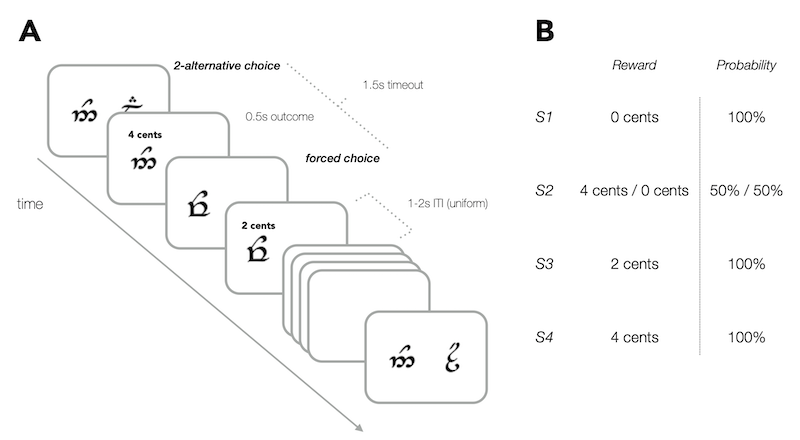

In [ ]:
fig = Image(filename=('task.png'))
fig

There were 9 different types of trials. In the first 5 trialtypes, the agent had two options (=actions) available. Trials with two options available are called "2-alternative choice" trials. In the last 4 trialtypes, the agent had one option available. Trials with only one option available are called "forced choice" trials, because the participant can only select the available option. The task was designed this way in order to ensure that human sample all options enough times to learn their values. 

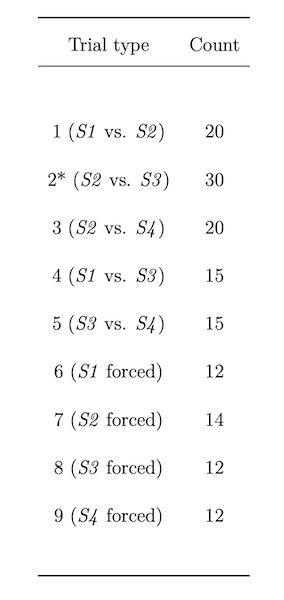

In [ ]:
fig = Image(filename=('trialtypes.png'))
fig

# Data preprocessing.

In [ ]:
# Print some sample data from one participant.
subj_id = 1
n_trials_to_print = 15

# picking one participant
subj_data = rl_data[rl_data['subj'] == subj_id]
subj_data = subj_data.dropna()
for t in subj_data['trial'][:n_trials_to_print]: # for each trial
    
    action = subj_data[subj_data['trial'] == t]['response'].values[0]
    reward = subj_data[subj_data['trial'] == t]['outcome'].values[0].astype(int)
    
    print(f'On trial ' + str(t) + ', participant ' + str(subj_id) + ' chose ' + action + ' and received a reward of ' + str(reward));

On trial 1, participant 1 chose S2 and received a reward of 4
On trial 2, participant 1 chose S1 and received a reward of 0
On trial 3, participant 1 chose S2 and received a reward of 0
On trial 4, participant 1 chose S3 and received a reward of 2
On trial 5, participant 1 chose S2 and received a reward of 0
On trial 6, participant 1 chose S1 and received a reward of 0
On trial 7, participant 1 chose S1 and received a reward of 0
On trial 8, participant 1 chose S3 and received a reward of 2
On trial 9, participant 1 chose S3 and received a reward of 2
On trial 10, participant 1 chose S2 and received a reward of 4
On trial 11, participant 1 chose S3 and received a reward of 2
On trial 12, participant 1 chose S4 and received a reward of 4
On trial 13, participant 1 chose S4 and received a reward of 4
On trial 14, participant 1 chose S4 and received a reward of 4
On trial 15, participant 1 chose S1 and received a reward of 0


In [ ]:
# Make data dictionary for passing to the agent.
data = {
    "states": subj_data['trialtype'].values,
    "actions": subj_data['response'].values,
    "outcomes": subj_data['outcome'].values
}
data

{'states': array([3, 1, 2, 8, 7, 1, 6, 8, 8, 7, 4, 9, 3, 9, 6, 9, 9, 8, 7, 6, 6, 5,
        5, 7, 4, 2, 2, 1, 5, 4, 5, 8, 7, 6, 3, 8, 3, 5, 9, 9, 9, 6, 3, 2,
        2, 2, 4, 4, 2, 9, 8, 7, 2, 8, 9, 3, 3, 1, 2, 7, 4, 3, 2, 1, 7, 7,
        3, 5, 5, 7, 2, 3, 9, 3, 6, 8, 5, 2, 2, 2, 2, 4, 2, 3, 1, 1, 2, 2,
        3, 2, 8, 6, 1, 1, 1, 3, 2, 3, 4, 7, 3, 1, 7, 1, 5, 5, 2, 7, 6, 6,
        1, 6, 2, 1, 8, 8, 4, 7, 3, 2, 4, 2, 8, 1, 2, 8, 3, 5, 8, 4, 9, 7,
        7, 4, 9, 6, 9, 4, 5, 3, 9, 5, 5, 3, 6, 2, 1, 6, 1, 2, 1, 6, 1, 2,
        1, 2, 9, 5, 9, 4, 6, 1, 4, 8, 5, 2, 3, 2, 7, 3, 4, 1, 7, 2, 4, 5]),
 'actions': array(['S2', 'S1', 'S2', 'S3', 'S2', 'S1', 'S1', 'S3', 'S3', 'S2', 'S3',
        'S4', 'S4', 'S4', 'S1', 'S4', 'S4', 'S3', 'S2', 'S1', 'S1', 'S4',
        'S4', 'S2', 'S3', 'S3', 'S3', 'S2', 'S4', 'S3', 'S4', 'S3', 'S2',
        'S1', 'S4', 'S3', 'S4', 'S4', 'S4', 'S4', 'S4', 'S1', 'S4', 'S3',
        'S3', 'S3', 'S3', 'S3', 'S3', 'S4', 'S3', 'S2', 'S3', 'S3', 'S4',
        'S4', '

# Define agent classes. 



## Q-Learning
For this agent, each trial type corresponds to a state with one or two actions. So we first have to make a helper variable that tells the agent which actions are availble in which state (see table above). 

In [ ]:
# binary indicator for "can take" action1, action2, action3, action4. 9 types of trials. 
valid_actions = np.array(
    [[1, 1, 0, 0],
    [0, 1, 1, 0],
    [0, 1, 0, 1],
    [1, 0, 1, 0],
    [0, 0, 1, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]]
)

In [ ]:
class QLearningAgent(object):
    """ Container for Q-Learning agent properties and methods.

    Parameters.
    ----------
    alpha: float
        Learning rate.
    beta: float
        Softmax temperature for choice linking function.
    ----------
    """

    def __init__(self, params):
        """ Sets agent parameters.
        """
        
        self.alpha = params['learning_rate']   
        self.beta = params['softmax_temperature']  # spreads probabilties, higher tempreature = less confident, closer to uniform
        self.gamma = params['discount_factor']
        
        self.n_states = params['n_states']
        self.n_actions = params['n_actions']
        
        print('Initialized agent with: ')
        print('Learning rate: ' + str(self.alpha))
        print('Softmax temperature: ' + str(self.beta))
        print('Discount factor: ' + str(self.gamma))
     
    def softmax(self, q):
        """ Softmax action selection for an arbitrary number of actions with values q.
            Ref. on logsumexp: https://blog.feedly.com/tricks-of-the-trade-logsumexp/

            Parameters
            ----------
            q: array, float
                Array of q-values.

            Returns
            -------
            p_c: array, float bounded between 0 and 1
                Probability distribution over actions
            a: int 
                Chosen action.
        """

        # Convert values to choice probabilities.
        # basically converts different Q values to probability of choosing, weighted by how the Q values in comparison to each other.
        q_b = self.beta * q;
        p_c = np.exp(q_b - logsumexp(q_b)); 

        # Uniformly sample from cumulative distribution over p_c.
        a = np.nonzero(np.random.random((1,)) <= np.cumsum(p_c))[0][0] + 1

        return p_c, a
    
    def choice_likelihood(self, data):
   
        """ Returns the log-likelihood of a sequence of actions under a Q-Learning model. 
            
            Parameters
            ----------
    
            data: dictionary of data variables. 
            
            Contains: 

            states: int, shape(n_trials, 1)
                Sequence of states. 
      
            actions: int, shape(n_trials, 1)
                Sequence of actions.

            outcomes: int, shape(n_trials, 1)
                Sequence of reward outcomes. 

            Returns
            -------
            rpe_all: float, array(n_trials, 1)
                Sequence of prediction errors.
            
            log_lik: float
                Log-likelihood of the data.
        """

        # Remap dictionary to necessary local variables. 
        states = data["states"]
        actions = data["actions"]
        outcomes = data["outcomes"]
         
        # Get number of trials.
        n_trials = len(outcomes)
   
        # Initialize q-values.
        # note that each trial type gets its own Q value
        q_values = np.zeros((self.n_states, self.n_actions))
        
        # Initialize latent variables. 
        rpe_all = np.zeros(n_trials)

        # Initialize log-likelihood.
        log_lik = 0
        
        # Initialize number of effective trials (= trials that actually go into the likelihood).
        n_trials_eff = 1

        # Loop through trials. 
        for t in np.arange(n_trials-1):
            
            print(q_values)

            # Grab state and action:
            state = states[t]
            
            print('State: ' + str(state))
            
            # Grab actions available in the state. 
            possible_actions = list(np.where(valid_actions[state-1])[0]+1) # calling our binary variable indices
            print('Possible actions: ' + str(possible_actions))
            
            # which action did they actually take for this trial
            if (actions[t] == 'S1'): # remap to integers for ease of indexing
                action = 1
            elif (actions[t] == 'S2'):
                action = 2
            elif (actions[t] == 'S3'):
                action = 3
            elif (actions[t] == 'S4'):
                action = 4
                
            print('Participant action: ' + str(action))
            
            # Grab q-values for actions that are possible in the state.
            q_values_trial = q_values[state-1, np.where(valid_actions[state-1])]
         
            # Compute action likelihood.
            if (q_values_trial.shape[1] == 2): # only add 2-alternative choices to the likelihood (but still learn from forced choices)
                p_c, a = self.softmax(q_values_trial) # given 2 Q action-value for the two possible actions, get the "optimal" probability of taking the Q-action.
                #print('Probability of each possible action under the model: ' + str(p_c))
                log_p_c = np.log(p_c).T 
                action_idx = possible_actions.index(action)
                
                trial_lik = log_p_c[action_idx] # calculates the likelihood of the agent taking this action, given our model of the agent.
                
                n_trials_eff = n_trials_eff + 1 # only count trials where agents have a choice. 
            else: 
                trial_lik = 0
            
            # adding up the likelihoods (can only be positive and increasing)
            log_lik = log_lik + trial_lik

            # Observe outcome and next state. 
            # Not very realistic for human trials, as they don't see the next stage, but is part of the Q-learning model wae ar
            outcome = outcomes[t].astype(int)
            print('Outcome: ' + str(outcome))
            
            next_state = states[t+1].astype(int)
            print('Next state: ' + str(next_state))
            
            # get the Q values for the next state and action
            q_values_next_state = q_values[next_state-1, np.where(valid_actions[next_state-1])]

            ## Perform update.
            # Compute prediction error. 
            # for q learning, we take the action that is best according to agent's current Q action-value belief.
            rpe = outcome + self.gamma * np.max(q_values_next_state) - q_values[state-1, action-1] # -1 due to the way we set up indexing.
            rpe_all[t] = rpe # store error for this step.
            
            # Apply update to our Q values.
            q_values[state-1, action-1] = q_values[state-1, action-1] + self.alpha * rpe
        
        latents = { 
            "rpe": rpe_all
        }
        
        lik_per_trial = np.exp(log_lik/n_trials_eff)
        print("Likelihood per trial " + str(lik_per_trial))
        
        # We return the negative log-likelihood in order to use the scipy "minimize" function
        return -log_lik[0], latents


# Test likelihood function. 

In [ ]:
# Instantiate agent with arbitrary parameters.
params = {'learning_rate': 0.2, 
          'discount_factor': 0,
          'softmax_temperature': 3,
          'n_states': 9,
          'n_actions': 4}

agent_q = QLearningAgent(params)
NLL, latents = agent_q.choice_likelihood(data)
print("Negative log-likelihood of participant's data: " + str(NLL))

Initialized agent with: 
Learning rate: 0.2
Softmax temperature: 3
Discount factor: 0
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
State: 3
Possible actions: [2, 4]
Participant action: 2
Outcome: 4
Next state: 1
[[0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.8 0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]]
State: 1
Possible actions: [1, 2]
Participant action: 1
Outcome: 0
Next state: 2
[[0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.8 0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]]
State: 2
Possible actions: [2, 3]
Participant action: 2
Outcome: 0
Next state: 8
[[0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.8 0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]]
State: 8
Possible a

# Parameter estimation. 

We would now like to find the parameters that maximize the likelihood of the data from one participant. Our parameters are: 

+ $\alpha$: learning rate
+ $\beta$: softmax temperature
+ $\gamma$: discount factor

In [ ]:
def train_model_q(training_params, data):
    params = {'learning_rate': training_params[0], 
          'softmax_temperature': training_params[1],
          'discount_factor': training_params[2],
          'n_states': 9,
          'n_actions': 4}
    
    agent_q = QLearningAgent(params)
    NLL, latents = agent_q.choice_likelihood(data)
    return NLL

In [ ]:
start_time = time.time()

# Set bounds.
bnds = [(1e-6,1), (1e-6,100), (1e-6,1)]

# Set parameter (learning, temperature, discount) initial conditions. Can't start at 0 as in most optimization, as otherwise wouldn't learn. 
init_conds = [np.random.uniform(0, 1), 
             np.random.uniform(1, 5), 
             np.random.uniform(0, 1)]

# Train and optimize our model.
# searches for the parameters that lead explain the agent's actions with the lowest negative log likelihood (highest likelihood)
# uses gradient descent like algorithm

#print(init_conds)
res = minimize(train_model_q, 
               init_conds, 
               args=(data), 
               method='L-BFGS-B', 
               bounds=bnds, 
               options={'maxfun': 700, 'maxiter': 300, 'maxls': 50})

# print('Maximum likelihood parameter estimates: ')
# print('Learning rate: ' + str(res.x[0]))
# print('Softmax temperature: ' + str(res.x[1]))
# print('Discount factor: ' + str(res.x[2]))

elapsed_time = time.time() - start_time
#print('elapsed time: ' + str((np.round(elapsed_time,decimals=3))) + ' seconds')

What do these MLE parameters tell us about the participant's learning process?

# Latent variable inference.

With the maximum likelihood parameter estimates in hand, we can now visualize "latent variables" that, according to our model, the participant experienced, but we cannot observe directly. One example are reward prediction errors. We can infer the RPEs by "running the model forward" with the best fit parameters. 

In [ ]:
%%capture
# Instantiate agent with MLE parameters.
params = {'learning_rate': res.x[0], 
          'discount_factor': res.x[1],
          'softmax_temperature': res.x[2],
          'n_states': 9,
          'n_actions': 4}

agent_q = QLearningAgent(params)
NLL, latents = agent_q.choice_likelihood(data)

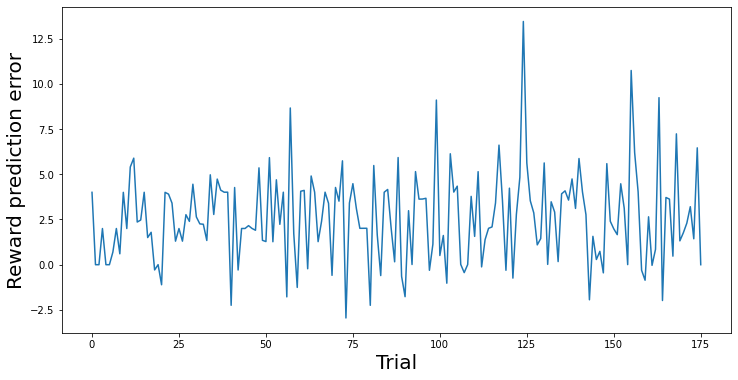

In [ ]:
# Visualize RPEs.
fig, ax = plt.subplots(1, 1, figsize=(12,6));
plt.plot(latents['rpe']);
ax.set_xlabel('Trial', fontsize=20)
ax.set_ylabel('Reward prediction error', fontsize=20);

# Same Thing as above, but with SARSA

In [ ]:
class SARSAAgent(object):
    """ Container for SARSA agent properties and methods.

    Parameters.
    ----------
    alpha: float
        Learning rate.
    beta: float
        Softmax temperature for choice linking function.
    ----------
    """

    def __init__(self, params):
        """ Sets agent parameters.
        """
        
        self.alpha = params['learning_rate']   
        self.beta = params['softmax_temperature']  # spreads probabilties, higher tempreature = less confident, closer to uniform
        self.gamma = params['discount_factor']
        
        self.n_states = params['n_states']
        self.n_actions = params['n_actions']
        
#         print('Initialized agent with: ')
#         print('Learning rate: ' + str(self.alpha))
#         print('Softmax temperature: ' + str(self.beta))
#         print('Discount factor: ' + str(self.gamma))
     
    def softmax(self, q):
        """ Softmax action selection for an arbitrary number of actions with values q.
            Ref. on logsumexp: https://blog.feedly.com/tricks-of-the-trade-logsumexp/

            Parameters
            ----------
            q: array, float
                Array of q-values.

            Returns
            -------
            p_c: array, float bounded between 0 and 1
                Probability distribution over actions
            a: int 
                Chosen action.
        """

        # Convert values to choice probabilities.
        # basically converts different Q values to probability of choosing, weighted by how the Q values in comparison to each other.
        # this is our "policy" by which we chose actions given knowledge of the world.
        q_b = self.beta * q;
        p_c = np.exp(q_b - logsumexp(q_b)); 

        # Uniformly sample from cumulative distribution over p_c.
        a = np.nonzero(np.random.random((1,)) <= np.cumsum(p_c))[0][0] + 1

        return p_c, a
    
    def choice_likelihood(self, data):
   
        """ Returns the log-likelihood of a sequence of actions under a Q-Learning model. 
            
            Parameters
            ----------
    
            data: dictionary of data variables. 
            
            Contains: 

            states: int, shape(n_trials, 1)
                Sequence of states. 
      
            actions: int, shape(n_trials, 1)
                Sequence of actions.

            outcomes: int, shape(n_trials, 1)
                Sequence of reward outcomes. 

            Returns
            -------
            rpe_all: float, array(n_trials, 1)
                Sequence of prediction errors.
            
            log_lik: float
                Log-likelihood of the data.
        """

        # Remap dictionary to necessary local variables. 
        states = data["states"]
        actions = data["actions"]
        outcomes = data["outcomes"]
         
        # Get number of trials.
        n_trials = len(outcomes)
   
        # Initialize q-values.
        # note that each trial type gets its own Q value
        q_values = np.zeros((self.n_states, self.n_actions))
        
        # Initialize latent variables. 
        rpe_all = np.zeros(n_trials)

        # Initialize log-likelihood.
        log_lik = 0
        
        # Initialize number of effective trials (= trials that actually go into the likelihood).
        n_trials_eff = 1

        # Loop through trials. 
        for t in np.arange(n_trials-1):
            #print(f'Trial Number: {t}')
            #print(q_values)

            # Grab state and action:
            state = states[t]
            
            #print('State: ' + str(state))
            
            # Grab actions available in the state. 
            possible_actions = list(np.where(valid_actions[state-1])[0]+1) # calling our binary variable indices
            #print('Possible actions: ' + str(possible_actions))
            
            # which action did they actually take for this trial
            if (actions[t] == 'S1'): # remap to integers for ease of indexing
                action = 1
            elif (actions[t] == 'S2'):
                action = 2
            elif (actions[t] == 'S3'):
                action = 3
            elif (actions[t] == 'S4'):
                action = 4
                
            #print('Participant action: ' + str(action))
            
            # Grab q-values for actions that are possible in the state.
            q_values_trial = q_values[state-1, np.where(valid_actions[state-1])]
         
            # Compute action likelihood.
            if (q_values_trial.shape[1] == 2): # only add 2-alternative choices to the likelihood (but still learn from forced choices)
                p_c, a = self.softmax(q_values_trial) # given 2 Q action-value for the two possible actions, get the "optimal" probability of taking the Q-action.
                #print('Probability of each possible action under the model: ' + str(p_c))
                log_p_c = np.log(p_c).T 
                action_idx = possible_actions.index(action)
                
                trial_lik = log_p_c[action_idx] # calculates the likelihood of the agent taking this action, given our model of the agent.
                
                n_trials_eff = n_trials_eff + 1 # only count trials where agents have a choice. 
            else: 
                trial_lik = 0
            
            # adding up the likelihoods (can only be positive and increasing)
            log_lik = log_lik + trial_lik

            # Observe outcome and next state. 
            # Not very realistic for human trials, as they don't see the next stage, but is part of the SARSA model we are trying to fit. 
            outcome = outcomes[t].astype(int)
            #print('Outcome: ' + str(outcome))
            
            next_state = states[t+1].astype(int)
            #print('Next state: ' + str(next_state))
            
            # use these Q values to get the next action the agent would take.
            # this is the SARSA 'on-policy' evaluation using our softmax policy.
            # which action did they actually take for this trial. 
            # since we are assuming they follow SARSA softmax, we will just look at what action they chose.
            
            if (actions[t+1] == 'S1'): # remap to integers for ease of indexing
                next_action = 1
            elif (actions[t+1] == 'S2'):
                next_action = 2
            elif (actions[t+1] == 'S3'):
                next_action = 3
            elif (actions[t+1] == 'S4'):
                next_action = 4
                
            
            ## Perform update.
            # Compute prediction error. 
            # for SARSA, we take the on policy Q-value for next state and next action (selected by policy).
            rpe = outcome + self.gamma * q_values[next_state -1, next_action - 1] - q_values[state-1, action-1] # -1 due to the way we set up indexing.
            rpe_all[t] = rpe # store error for this step.
            
            # Apply update to our Q values. rpe is the "TD_target" that drives learning
            q_values[state-1, action-1] = q_values[state-1, action-1] + self.alpha * rpe
        
        latents = { 
            "rpe": rpe_all
        }
        
        lik_per_trial = np.exp(log_lik[0]/n_trials_eff)
        #print("Likelihood per trial " + str(lik_per_trial))
        
        # We return the negative log-likelihood in order to use the scipy "minimize" function
        return -log_lik[0], latents


In [ ]:
def train_model_sarsa(training_params, data):
    params = {'learning_rate': training_params[0], 
          'softmax_temperature': training_params[1],
          'discount_factor': training_params[2],
          'n_states': 9,
          'n_actions': 4}
    
    agent_sarsa = SARSAAgent(params)
    NLL, latents = agent_sarsa.choice_likelihood(data)
    return NLL

In [ ]:
start_time = time.time()

# Set bounds.
bnds = [(1e-6,1), (1e-6,100), (1e-6,1)]

# Set parameter (learning, temperature, discount) initial conditions. Can't start at 0 as in most optimization, as otherwise wouldn't learn. 
init_conds = [np.random.uniform(0, 1), 
             np.random.uniform(1, 5), 
             np.random.uniform(0, 1)]

# Train and optimize our model.
# searches for the parameters that lead explain the agent's actions with the lowest negative log likelihood (highest likelihood)
# uses gradient descent like algorithm

#print(init_conds)
res = minimize(train_model_sarsa, 
               init_conds, 
               args=(data), 
               method='L-BFGS-B', 
               bounds=bnds, 
               options={'maxfun': 700, 'maxiter': 300, 'maxls': 50})

print('Maximum likelihood parameter estimates: ')
print('Learning rate: ' + str(res.x[0]))
print('Softmax temperature: ' + str(res.x[1]))
print('Discount factor: ' + str(res.x[2]))

elapsed_time = time.time() - start_time
#print('elapsed time: ' + str((np.round(elapsed_time,decimals=3))) + ' seconds')

Maximum likelihood parameter estimates: 
Learning rate: 0.7740034479631405
Softmax temperature: 0.30285772006544337
Discount factor: 0.9467893237340786


In [ ]:
# Instantiate agent with MLE parameters.
params = {'learning_rate': res.x[0], 
          'discount_factor': res.x[1],
          'softmax_temperature': res.x[2],
          'n_states': 9,
          'n_actions': 4}

agent_sarsa = SARSAAgent(params)
NLL, latents = agent_sarsa.choice_likelihood(data)
print("Negative log-likelihood of participant's data: " + str(NLL))

Negative log-likelihood of participant's data: 51.67230368835179


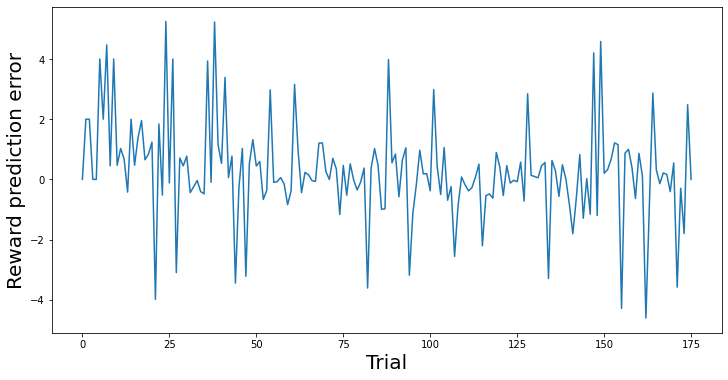

In [ ]:
# Visualize RPEs.
fig, ax = plt.subplots(1, 1, figsize=(12,6));
plt.plot(latents['rpe']);
ax.set_xlabel('Trial', fontsize=20)
ax.set_ylabel('Reward prediction error', fontsize=20);

### TD-Learning agent with 4 states.

Unlike in the Q-Learning set up, in which trial types correspond to states, and stimuli correspond to actions, in this algorithm participants treat each of the 4 stimuli in the task as its own state, 
and generalize across trial types (e.g. the value of S1 is the same whether it appears 
by itself or paired with another state).
+ S1 corresponds to state 1
+ S2 corresponds to state 2
+ S3 corresponds to state 3
+ S4 corresponds to state 4

Participants choose which state to visit using softmax action selection: they are most 
likely to visit the state with the highest value, but sometimes explore other states.

Assume no discounting, since participants have no control over what state comes next.

In [ ]:
# Make data dictionary for passing to the td-learning agent.
valid_states = np.array(
    [[1, 1, 0, 0],
    [0, 1, 1, 0],
    [0, 1, 0, 1],
    [1, 0, 1, 0],
    [0, 0, 1, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]]
)

td_learning_data = {
    "states": subj_data['response'].values,
    "outcomes": subj_data['outcome'].values,
    "trialtypes": subj_data['trialtype'].values
}
td_learning_data

{'states': array(['S1', 'S3', 'S3', 'S2', 'S1', 'S4', 'S3', 'S2', 'S3', 'S4', 'S1',
        'S3', 'S3', 'S3', 'S3', 'S1', 'S3', 'S4', 'S2', 'S1', 'S2', 'S2',
        'S4', 'S4', 'S4', 'S4', 'S2', 'S2', 'S2', 'S3', 'S3', 'S4', 'S2',
        'S1', 'S3', 'S3', 'S2', 'S3', 'S2', 'S4', 'S4', 'S2', 'S2', 'S2',
        'S2', 'S1', 'S3', 'S2', 'S2', 'S3', 'S4', 'S3', 'S4', 'S2', 'S2',
        'S3', 'S3', 'S4', 'S2', 'S3', 'S2', 'S2', 'S2', 'S4', 'S1', 'S1',
        'S3', 'S3', 'S4', 'S4', 'S4', 'S2', 'S1', 'S4', 'S4', 'S2', 'S4',
        'S3', 'S3', 'S3', 'S3', 'S3', 'S2', 'S3', 'S2', 'S2', 'S2', 'S1',
        'S2', 'S4', 'S4', 'S4', 'S1', 'S4', 'S2', 'S2', 'S3', 'S2', 'S2',
        'S2', 'S3', 'S2', 'S1', 'S4', 'S3', 'S4', 'S1', 'S2', 'S4', 'S1',
        'S4', 'S1', 'S3', 'S3', 'S4', 'S2', 'S4', 'S1', 'S2', 'S4', 'S4',
        'S4', 'S3', 'S4', 'S3', 'S3', 'S4', 'S3', 'S2', 'S3', 'S4', 'S3',
        'S4', 'S4', 'S2', 'S4', 'S4', 'S4', 'S3', 'S4', 'S3', 'S2', 'S2',
        'S3', 'S4', 'S2', 'S

In [ ]:
class TDLearningAgent(object):
    """ Container for TD-Learning agent properties and methods.

    Parameters.
    ----------
    alpha: float
        Learning rate.
    beta: float
        Softmax temperature for choice linking function.
    ----------
    """

    def __init__(self, params):
        """ Sets agent parameters.
        """
        
        self.alpha = params['learning_rate']   
        self.beta = params['softmax_temperature']
       
        self.n_states = params['n_states']
        
#         print('Initialized agent with: ')
#         print('Learning rate: ' + str(self.alpha))
#         print('Softmax temperature: ' + str(self.beta))
       
    def softmax(self, v):
        """ Softmax action selection for an arbitrary number of states with values v.
            Ref. on logsumexp: https://blog.feedly.com/tricks-of-the-trade-logsumexp/

            Parameters
            ----------
            v: array, float
                Array of v-values.

            Returns
            -------
            p_c: array, float bounded between 0 and 1
                Probability distribution over actions
            a: int 
                Chosen action.
        """

        # Convert values to choice probabilities.
        v_b = self.beta * v;
        p_c = np.exp(v_b - logsumexp(v_b));

        # Uniformly sample from cumulative distribution over p_c.
        a = np.nonzero(np.random.random((1,)) <= np.cumsum(p_c))[0][0] + 1
        
        return p_c, a
    
    def choice_likelihood(self, data):
   
        """ Returns the log-likelihood of a sequence of choices under a TD-Learning model. 
            
            Parameters
            ----------
    
            data: dictionary of data variables. 
            
            Contains: 

            states: str, shape(n_trials, 1)
                Sequence of states visited by participant. 

            outcomes: int, shape(n_trials, 1)
                Sequence of reward outcomes. 
                
            trialtypes: int, shape(n_trials, 1)
                Indicator variable telling us what type of trial we are in.

            Returns
            -------
            rpe_all: float, array(n_trials, 1)
                Sequence of prediction errors.
            
            log_lik: float
                Log-likelihood of the data.
        """

        # Remap dictionary to necessary local variables. 
        states = data["states"] 
        outcomes = data["outcomes"]
        trialtypes = data["trialtypes"]
         
        # Get number of trials.
        n_trials = len(outcomes)
   
        # Initialize values.
        values = np.zeros(self.n_states)
        
        # Initialize latent variables. 
        rpe_all = np.zeros(n_trials)

        # Initialize log-likelihood.
        log_lik = 0
        
        # Initialize number of effective trials (= trials that actually go into the likelihood).
        n_trials_eff = 0

        # Loop through trials. 
        for t in np.arange(n_trials):
            
            #print('Trial: ' + str(t+1))
            
            #print('State values: ')
            #print(values)
            
            # Grab states available on this trial. 
            trial_type = trialtypes[t].astype(int)
            #print('Trial type ' + str(trial_type))
            possible_states = list(np.where(valid_states[trial_type-1])[0]+1)
            #print('Possible states to visit: ' + str(possible_states))
 
            # Grab state that participant actually visited.             
            if (states[t] == 'S1'): # remap to integers for ease of indexing
                state = 1
            elif (states[t] == 'S2'):
                state = 2
            elif (states[t] == 'S3'):
                state = 3
            elif (states[t] == 'S4'):
                state = 4
                 
            # Grab values for possible states to visit. 
            values_trial = values[np.array(possible_states)-1]
         
            # Compute action likelihood.
            if (values_trial.shape[0] == 2): # only add 2-alternative choices to the likelihood (but still learn from forced choices)
                p_c, _ = self.softmax(values_trial)
                #print('Probability of visiting each state: ' + str(p_c))
                log_p_c = np.log(p_c).T 
                choice_idx = possible_states.index(state)
                
                trial_lik = log_p_c[choice_idx]
                
                n_trials_eff = n_trials_eff + 1
            else: 
                trial_lik = 0
                            
            log_lik = log_lik + trial_lik
            #print('Visited state: ' + str(state))

            # Observe outcome. 
            outcome = outcomes[t].astype(int)
            #print('Outcome: ' + str(outcome))
            
            ## Perform update.
            
            # Compute prediction error. 
            rpe = outcome - values[state-1]
            rpe_all[t] = rpe
            
            # Apply update.
            values[state-1] = values[state-1] + self.alpha * rpe
        
        latents = { 
            "rpe": rpe_all
        }
        
        lik_per_trial = np.exp(log_lik/n_trials_eff)
        #print("Likelihood per trial " + str(lik_per_trial))
        
        # We return the negative log -likelihood in order to use the scipy "minimize" function
        return -log_lik, latents


In [ ]:
def train_model_td(training_params, data):
    params = {'learning_rate': training_params[0], 
          'softmax_temperature': training_params[1],
          'n_states': 9,
          'n_actions': 4}
    
    agent_td = TDLearningAgent(params)
    NLL, latents = agent_td.choice_likelihood(data)
    return NLL

In [ ]:
start_time = time.time()

# Set bounds.
bnds = [(1e-6,1), (1e-6,100)]

# Set parameter (learning, temperature) initial conditions. Can't start at 0 as in most optimization, as otherwise wouldn't learn. 
init_conds = [np.random.uniform(0, 1), 
             np.random.uniform(1, 5)]

# Train and optimize our model.
# searches for the parameters that lead explain the agent's actions with the lowest negative log likelihood (highest likelihood)
# uses gradient descent like algorithm

#print(init_conds)
res = minimize(train_model_td, 
               init_conds, 
               args=(td_learning_data), 
               method='L-BFGS-B', 
               bounds=bnds, 
               options={'maxfun': 700, 'maxiter': 300, 'maxls': 50})

# print('Maximum likelihood parameter estimates: ')
# print('Learning rate: ' + str(res.x[0]))
# print('Softmax temperature: ' + str(res.x[1]))

elapsed_time = time.time() - start_time
#print('elapsed time: ' + str((np.round(elapsed_time,decimals=3))) + ' seconds')

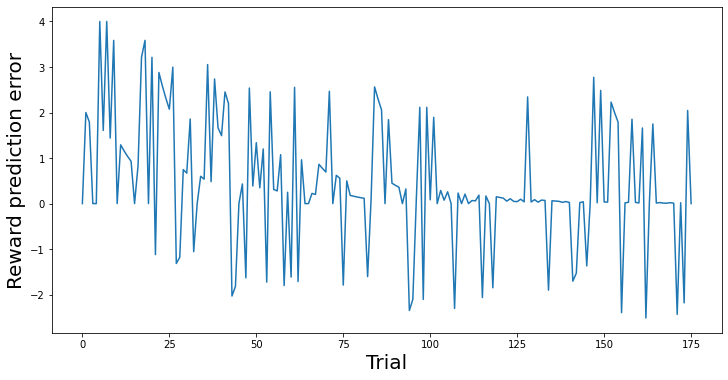

In [ ]:
# Instantiate agent with MLE parameters.
params = {'learning_rate': res.x[0], 
          'softmax_temperature': res.x[1],
          'n_states': 9,
          'n_actions': 4}

agent_td = TDLearningAgent(params)
NLL, latents = agent_td.choice_likelihood(td_learning_data)

fig, ax = plt.subplots(1, 1, figsize=(12,6));
plt.plot(latents['rpe']);
ax.set_xlabel('Trial', fontsize=20)
ax.set_ylabel('Reward prediction error', fontsize=20);

# Model comparison.

In [ ]:
# loop through all participants
from tqdm import tqdm

df_q = pd.DataFrame(columns = ['Learning-Rates', 'Discount-Factors', 'Temperatures', 'NegativeLLs', 'RewardPredErr'])
df_s = pd.DataFrame(columns = ['Learning-Rates', 'Discount-Factors', 'Temperatures', 'NegativeLLs', 'RewardPredErr'])
df_td = pd.DataFrame(columns = ['Learning-Rates', 'Discount-Factors', 'Temperatures', 'NegativeLLs', 'RewardPredErr'])

for subj in tqdm(range(1, len(rl_data.subj.unique())-1)):
    
    # pick one participant, remove NAs (no choice)
    subj_data = rl_data[rl_data['subj'] == subj]
    subj_data= subj_data.dropna()

    # Make data dictionary for passing to the agent.
    data = {
        "states": subj_data['trialtype'].values,
        "actions": subj_data['response'].values,
        "outcomes": subj_data['outcome'].values
    }
    
    # TD value based learning has a slightly different set up
    td_learning_data = {
        "states": subj_data['response'].values,
        "outcomes": subj_data['outcome'].values,
        "trialtypes": subj_data['trialtype'].values
    }

    start_time = time.time()

    # Set bounds.
    bnds = [(1e-6,1), (1e-6,100), (1e-6,1)]

    # Set parameter (learning, temperature, discount) initial conditions. Can't start at 0 as in most optimization, as otherwise wouldn't learn. 
    init_conds = [np.random.uniform(0, 1), 
                 np.random.uniform(2, 5), 
                 np.random.uniform(0, 1)]

    # Train and optimize our Q-Learning model
    res = minimize(train_model_q, 
                   init_conds, 
                   args=(data), 
                   method='L-BFGS-B', 
                   bounds=bnds, 
                   options={'maxfun': 300, 'maxiter': 200, 'maxls': 50})
    
    # getting the best parameters
    params = {'learning_rate': res.x[0], 
          'discount_factor': res.x[1],
          'softmax_temperature': res.x[2],
          'n_states': 9,
          'n_actions': 4}

    agent_q = QLearningAgent(params)
    NLL, latents = agent_q.choice_likelihood(data)
    
    
    # adding data to record
    df_q.loc[subj - 1] = [res.x[0], res.x[1], res.x[2], NLL, np.mean(latents['rpe'])]
    
    # Train and optimize our SARSA model
    res = minimize(train_model_sarsa, 
                   init_conds, 
                   args=(data), 
                   method='L-BFGS-B', 
                   bounds=bnds, 
                   options={'maxfun': 300, 'maxiter': 200, 'maxls': 50})
    
    params = {'learning_rate': res.x[0], 
              'discount_factor': res.x[1],
              'softmax_temperature': res.x[2],
              'n_states': 9,
              'n_actions': 4}

    agent_sarsa = SARSAAgent(params)
    NLL, latents = agent_sarsa.choice_likelihood(data)
    
    df_s.loc[subj - 1] = [res.x[0], res.x[1], res.x[2], NLL, np.mean(latents['rpe'])]
    
    # different number of hyperparamters for TD Learning
    bnds = [(1e-6,1), (1e-6,100)]
    
    init_conds = [np.random.uniform(0, 1), 
                 np.random.uniform(1, 5)]

    res = minimize(train_model_td, 
                   init_conds, 
                   args=(td_learning_data), 
                   method='L-BFGS-B', 
                   bounds=bnds, 
                   options={'maxfun': 700, 'maxiter': 300, 'maxls': 50})

    params = {'learning_rate': res.x[0], 
          'softmax_temperature': res.x[1],
          'n_states': 9,
          'n_actions': 4}

    agent_td = TDLearningAgent(params)
    NLL, latents = agent_td.choice_likelihood(td_learning_data)
    
    df_td.loc[subj - 1] = [res.x[0], 0, res.x[1], NLL, np.mean(latents['rpe'])]
    
    elapsed_time = time.time() - start_time
    #print('elapsed time: ' + str((np.round(elapsed_time,decimals=3))) + ' seconds')

 32%|███▏      | 178/561 [06:25<12:18,  1.93s/it]<ipython-input-150-59348f4e21c2>:139: RuntimeWarning: divide by zero encountered in log
  log_p_c = np.log(p_c).T
/Users/johnnyma/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 59%|█████▉    | 333/561 [11:48<07:01,  1.85s/it]<ipython-input-150-59348f4e21c2>:139: RuntimeWarning: divide by zero encountered in log
  log_p_c = np.log(p_c).T
/Users/johnnyma/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
<ipython-input-167-e3604ae7d8ef>:140: RuntimeWarning: divide by zero encountered in log
  log_p_c = np.log(p_c).T
 75%|███████▌  | 423/561 [15:02<06:26,  2.80s/it]<ipython-input-150-59348f4e21c2>:139: RuntimeWarning: divide by zero encountered in log
  log_p_c = np.log(p_c).T
/Users/johnnyma/opt/anaconda3/lib/python3.8/site-packages/scipy/optimiz

# Graphing our Tuned Hyperparamters

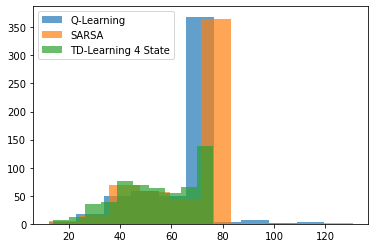

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.hist(df_q['NegativeLLs'], alpha = 0.7, label = 'Q-Learning')
plt.hist(df_s['NegativeLLs'], alpha = 0.7, label = 'SARSA')
plt.hist(df_td['NegativeLLs'], alpha = 0.7, label = 'TD-Learning 4 State')
plt.legend()

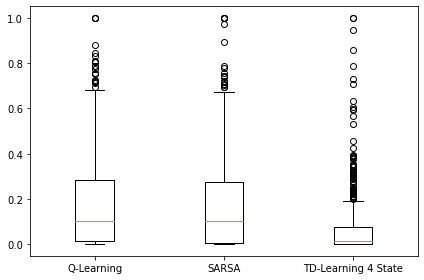

In [ ]:
plt.boxplot([df_q['Learning-Rates'], df_s['Learning-Rates'], df_td['Learning-Rates']])
plt.xticks([1,2,3], ('Q-Learning', 'SARSA', 'TD-Learning 4 State'))
plt.tight_layout()

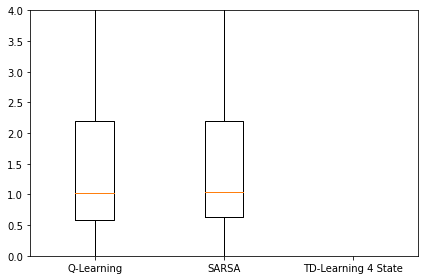

In [ ]:
plt.boxplot([df_q['Discount-Factors'], df_s['Discount-Factors'], df_td['Discount-Factors']])
plt.ylim([0,4])
plt.xticks([1,2,3], ('Q-Learning', 'SARSA', 'TD-Learning 4 State'))
plt.tight_layout()

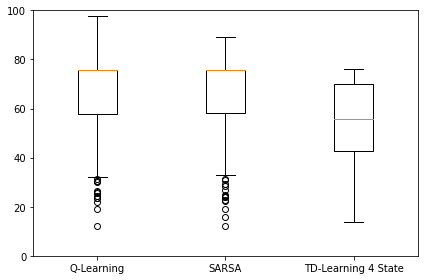

In [ ]:
plt.boxplot([df_q['NegativeLLs'], df_s['NegativeLLs'], df_td['NegativeLLs']])
plt.ylim([0,100])
plt.xticks([1,2,3], ('Q-Learning', 'SARSA', 'TD-Learning 4 State'))
plt.tight_layout()

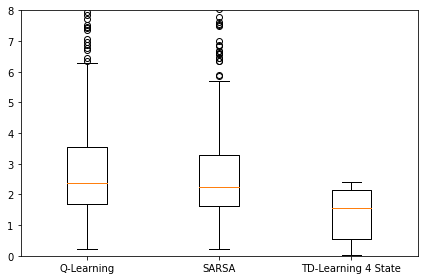

In [ ]:
plt.boxplot([df_q['RewardPredErr'], df_s['RewardPredErr'], df_td['RewardPredErr']])
plt.ylim([0,8])
plt.xticks([1,2,3], ('Q-Learning', 'SARSA', 'TD-Learning 4 State'))
plt.tight_layout()